### ПРОЕКТ М1 "ПРЕДСКАЗАНИЕ РИСКА СЕРДЕЧНОГО ПРИСТУПА НА ОСНОВЕ ДАННЫХ ПАЦИЕНТОВ"


    ЦЕЛЬ ПРОЕКТА:
Разработать модель и ее интерфейс для предсказания риска сердечного приступа на основе данных пациентов

   Описание исходных данных:
Данные пациентов для предсказания риска сердечных приступов
id  - id
Антропометрические параметры (вес, возраст, рост)
Привычки (курение, качество сна и т.д)
Давление
Наличие хронических заболеваний
Биохимия крови
Таргет - высокий или низкий риск поражения сердца

   Предполагается, что в ходе работы над проектом будут решены следующие задачи:
- Исследование датасета (предполагается поиск дополнительной информации для лучшего понимания природы данных)
- Предобработка данных. В данных могут быть бесполезные признаки, сильно скорелированные признаки а также косвенные утечки целевого признака. Некоторые колонки потребуется преобразовать к нужному типу данных.
- Обучение модели
Подготовка предсказания на тестовой выборке. Файл предсказаний должен быть в csv формате и содержать 2 столбца: “id” и “prediction”. 
- Подготовка скриптов и библиотеки для обработки данных и предсказания на тестовой выборке
- Написание инструмента для тестирования
- Оформление документации



In [36]:
!pip install --upgrade scikit-learn -q
!pip install shap -q
!pip install phik -q

In [71]:
# импортируем все библиотеки, которые будем использовать при выполнении проектной работы 

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from scipy import stats as st
from scipy.stats import binom, uniform
import joblib
import json

import shap

# Импорты моделей
from sklearn.model_selection import GridSearchCV, StratifiedKFold
from sklearn.ensemble import RandomForestClassifier, ExtraTreesClassifier


# Предобработка данных
from sklearn.preprocessing import StandardScaler, MinMaxScaler, OneHotEncoder, OrdinalEncoder
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

# Разделение данных и подбор гиперпараметров
from sklearn.model_selection import train_test_split, RandomizedSearchCV, GridSearchCV
from sklearn.preprocessing import FunctionTransformer

# Метрики оценки
from sklearn.metrics import (
    roc_auc_score, average_precision_score, f1_score,
    precision_recall_curve, classification_report
)

# Анализ зависимости признаков
from phik import resources
from phik.report import plot_correlation_matrix

1. ЗАГРУЗКА ДАННЫХ

In [38]:
heart_train = pd.read_csv('./heart_train.csv')
heart_test  = pd.read_csv('./heart_test.csv')

In [39]:
# Выведем первые строки каждого набора данных,  их размеры
display(heart_train.head(10))
display(heart_train.shape)



,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Physical Activity Days Per Week,Sleep Hours Per Day,Heart Attack Risk (Binary),Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.359551,0.732143,0.074244,1.0,1.0,1.0,1.0,1.0,0.535505,...,3.0,0.333333,0.0,0.227018,0.048229,0.036512,Male,0.212903,0.709302,2664
1,1,0.202247,0.325000,0.047663,1.0,1.0,0.0,0.0,1.0,0.068690,...,3.0,0.833333,0.0,0.150198,0.017616,0.000194,Female,0.412903,0.569767,9287
2,2,0.606742,0.860714,0.055912,1.0,0.0,1.0,1.0,1.0,0.944001,...,2.0,1.000000,0.0,0.227018,0.048229,0.036512,Female,0.238710,0.220930,5379
3,3,0.730337,0.007143,0.053162,0.0,0.0,1.0,0.0,1.0,0.697023,...,0.0,0.333333,1.0,0.227018,0.048229,0.036512,Female,0.348387,0.267442,8222
4,4,0.775281,0.757143,0.021998,0.0,0.0,1.0,0.0,1.0,0.412878,...,5.0,1.000000,1.0,0.227018,0.048229,0.036512,Male,0.619355,0.441860,4047
5,5,0.168539,0.764286,0.057745,0.0,1.0,1.0,1.0,1.0,0.082682,...,6.0,0.833333,0.0,0.227018,0.048229,0.036512,Male,0.464516,0.418605,5817
6,6,0.483146,0.021429,0.036664,1.0,0.0,1.0,0.0,1.0,0.540206,...,5.0,0.000000,1.0,0.231225,0.008940,0.000291,Male,0.361290,0.569767,5580
7,7,0.235955,0.939286,0.081577,1.0,0.0,1.0,0.0,1.0,0.290837,...,4.0,0.000000,0.0,0.227018,0.048229,0.036512,Male,0.690323,0.639535,4963
8,8,0.685393,0.317857,0.039413,0.0,0.0,1.0,0.0,0.0,0.803160,...,6.0,0.166667,1.0,0.126482,0.002332,0.007185,Male,0.664516,0.616279,4521
9,9,0.213483,0.796429,0.076994,1.0,1.0,1.0,1.0,0.0,0.506971,...,3.0,1.000000,0.0,0.227018,0.048229,0.036512,Male,0.651613,0.720930,2455


(8685, 28)

In [40]:
display(heart_test.head(10))
display(heart_test.shape)

,Unnamed: 0,Age,Cholesterol,Heart rate,Diabetes,Family History,Smoking,Obesity,Alcohol Consumption,Exercise Hours Per Week,...,Triglycerides,Physical Activity Days Per Week,Sleep Hours Per Day,Blood sugar,CK-MB,Troponin,Gender,Systolic blood pressure,Diastolic blood pressure,id
0,0,0.494382,0.264286,0.062328,0.0,1.0,1.0,1.0,1.0,0.361618,...,0.306494,1.0,0.333333,0.227018,0.048229,0.036512,Male,0.283871,0.372093,7746
1,1,0.224719,0.953571,0.082493,1.0,0.0,0.0,1.0,0.0,0.996483,...,0.087013,0.0,0.166667,0.227018,0.048229,0.036512,Female,0.703226,0.441860,4202
2,2,0.629213,0.092857,0.064161,0.0,1.0,1.0,1.0,0.0,0.995561,...,0.205195,7.0,1.000000,0.102767,0.002666,0.088455,Male,0.458065,0.779070,6632
3,3,0.460674,0.567857,0.055912,1.0,1.0,1.0,1.0,1.0,0.437277,...,0.163636,0.0,0.666667,0.203557,0.056390,0.271774,Female,0.741935,0.255814,4639
4,4,0.719101,0.485714,0.022915,1.0,0.0,1.0,0.0,1.0,0.514920,...,0.580519,5.0,0.000000,0.227018,0.048229,0.036512,Male,0.412903,0.395349,4825
5,5,0.561798,0.792857,0.026581,1.0,1.0,1.0,1.0,0.0,0.774470,...,0.362338,1.0,0.666667,0.227018,0.048229,0.036512,Male,0.161290,0.593023,1076
6,6,0.674157,0.853571,0.019248,1.0,1.0,1.0,0.0,1.0,0.149123,...,0.211688,3.0,0.000000,0.227018,0.048229,0.036512,Male,0.535484,0.546512,5020
7,7,0.539326,0.335714,0.036664,1.0,1.0,1.0,0.0,1.0,0.329720,...,0.835065,7.0,0.666667,0.695652,0.002466,0.000874,Male,0.496774,0.662791,4267
8,8,0.449438,0.328571,0.075160,1.0,0.0,1.0,0.0,0.0,0.487405,...,0.819481,2.0,0.166667,0.227018,0.048229,0.036512,Male,0.677419,0.430233,4003
9,9,0.617978,0.728571,0.032081,0.0,1.0,1.0,0.0,0.0,0.211485,...,0.196104,0.0,1.000000,0.227018,0.048229,0.036512,Male,0.722581,0.255814,2519


(966, 27)

Загрузили и изучили данные:

Обучающая выборка heart_train содержит 8685 строк, 28 столбцов

Тестовая выборка heart_test содержит 966 строк, 27 столбцов. В тестовой выборке отсуствует столбец с целевым признаком Heart Attack Risk (Binary). 

	Целевой признак: Heart Attack Risk (Binary) (0/1).
	ID: id.
	Колонка Unnamed: 0 - служебный столбец, выглядит как дубликат индекса, его удалим в предобработке.


Данные в таблицах соотвествуют описанию, выглядят полными и достаточными, можно переходить к предобработке данных

2. ПРЕДОБРАБОТКА ДАННЫХ

In [41]:
# зафиксируем константы
TARGET = "Heart Attack Risk (Binary)"
ID_COL = "id"

# Работаем с копиями для безопасной предобработки
data_tr = heart_train.copy()
data_te = heart_test.copy()

# удалим служебный столбец unnamed: 0
data_tr.drop(columns=['Unnamed: 0'], inplace=True)
data_te.drop(columns=['Unnamed: 0'], inplace=True)

# проверим и удалим точные дубликаты в обучающей выборке
before = len(data_tr)
data_tr = data_tr.drop_duplicates(ignore_index=True)
after = len(data_tr)
print(f"Дубликаты в train: удалено {before - after}")

Дубликаты в train: удалено 0


In [42]:
# обзор пропусков
null_share = data_tr.isna().mean().sort_values(ascending=False)
print("TOP по пропускам (train):")
display(null_share.head(10))

TOP по пропускам (train):


Physical Activity Days Per Week    0.027979
Diabetes                           0.027979
Family History                     0.027979
Smoking                            0.027979
Obesity                            0.027979
Alcohol Consumption                0.027979
Previous Heart Problems            0.027979
Medication Use                     0.027979
Stress Level                       0.027979
Troponin                           0.000000
dtype: float64

Пропуски наблюдаются в 9 колонках, сконцентрированы в признаках: Physical Activity Days Per Week, Diabetes, Family History, Smoking, Obesity Alcohol Consumption, Previous Heart Problems, Medication Use Stress Level. Пропуски заполним разумными значениями внутпри пайплайна, а не "руками".

In [43]:
# приведём имена столбцов к snake_case (для удобства)
data_tr.columns = [c.strip().lower().replace(" ", "_") for c in data_tr.columns]
data_te.columns = [c.strip().lower().replace(" ", "_") for c in data_te.columns]

In [44]:
TARGET = "heart_attack_risk_(binary)"  # обновляем константу под новые имена
ID_COL = "id"

In [45]:
# выделим числовые и категориальные признаки
X = data_tr.drop(columns=[TARGET, ID_COL])
num_cols = X.select_dtypes(include=[np.number]).columns.tolist()
cat_cols = [c for c in X.columns if c not in num_cols]

print("Числовых признаков:", len(num_cols), "Категориальных:", len(cat_cols))
print("Примеры числовых:", num_cols[:8])
print("Примеры категориальных:", cat_cols[:8])

Числовых признаков: 24 Категориальных: 1
Примеры числовых: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption']
Примеры категориальных: ['gender']


In [46]:
# проверим все числовые признаки на количество уникальных значений (скорее всего они категориальные)
suspected_cat = []
for col in num_cols:
    uniq = data_tr[col].nunique()
    if uniq <= 5:   
        suspected_cat.append((col, uniq, data_tr[col].unique()[:10]))

print("Признаки с малым числом уникальных значений:")
for col, uniq, vals in suspected_cat:
    print(f"{col}: {uniq} уникальных, примеры: {vals}")

Признаки с малым числом уникальных значений:
diabetes: 2 уникальных, примеры: [ 1.  0. nan]
family_history: 2 уникальных, примеры: [ 1.  0. nan]
smoking: 2 уникальных, примеры: [ 1.  0. nan]
obesity: 2 уникальных, примеры: [ 1.  0. nan]
alcohol_consumption: 2 уникальных, примеры: [ 1.  0. nan]
diet: 4 уникальных, примеры: [1 2 0 3]
previous_heart_problems: 2 уникальных, примеры: [ 1.  0. nan]
medication_use: 2 уникальных, примеры: [ 0.  1. nan]


 Бинарные признаки (0 / 1 / nan)
	•	diabetes
	•	family_history
	•	smoking
	•	obesity
	•	alcohol_consumption
	•	previous_heart_problems
	•	medication_use

 Это категориальные признаки, хотя записаны числами. Их правильнее трактовать как «Да/Нет» и обрабатывать как категориальные. Мы не будем переводить их в текст (типа "yes"/"no"), можно оставить как 0/1, но отдать в OneHotEncoder — он сам превратит их в бинарные столбцы.

  Diet (4 значения: 0,1,2,3)

Тут явно не числовая шкала , это закодированные категории указывающие на тип соблдаемого питания или т.п. Тоже будем считать категориальным признаком и кодируем через OHE.

In [47]:
binary_and_cats = [
    "diabetes", "family_history", "smoking", "obesity",
    "alcohol_consumption", "previous_heart_problems",
    "medication_use", "diet"
]

for col in binary_and_cats:
    if col in num_cols:
        num_cols.remove(col)
    if col not in cat_cols:
        cat_cols.append(col)

print("Числовых признаков осталось:", len(num_cols))
print("Категориальных стало:", len(cat_cols))

Числовых признаков осталось: 16
Категориальных стало: 9


In [48]:
# проверим уникальные значения для категориальных признаков
for col in cat_cols:
    uniq = data_tr[col].unique()
    print(f"{col} → {len(uniq)} уникальных: {uniq[:10]}")

gender → 4 уникальных: ['Male' 'Female' '1.0' '0.0']
diabetes → 3 уникальных: [ 1.  0. nan]
family_history → 3 уникальных: [ 1.  0. nan]
smoking → 3 уникальных: [ 1.  0. nan]
obesity → 3 уникальных: [ 1.  0. nan]
alcohol_consumption → 3 уникальных: [ 1.  0. nan]
previous_heart_problems → 3 уникальных: [ 1.  0. nan]
medication_use → 3 уникальных: [ 0.  1. nan]
diet → 4 уникальных: [1 2 0 3]


In [49]:
# приводим колонку gender к единому виду
def clean_gender(val):
    val = str(val).lower().strip()
    if val in ["male", "1.0", "1"]:
        return "male"
    elif val in ["female", "0.0", "0"]:
        return "female"
    else:
        return np.nan   

data_tr["gender"] = data_tr["gender"].apply(clean_gender)
data_te["gender"] = data_te["gender"].apply(clean_gender)

print("Уникальные значения gender в train:", data_tr["gender"].unique())
print("Уникальные значения gender в test :", data_te["gender"].unique())

Уникальные значения gender в train: ['male' 'female']
Уникальные значения gender в test : ['male' 'female']


В процессе предобработки данных было сделано:

	1.	Удалили служебный столбец Unnamed: 0 и дубликаты строк в train, чтобы они не мешали обучению.

	2.	Привели имена колонок к snake_case — теперь работать с ними удобнее и ошибки из-за пробелов/регистрa исключены.

	3.	Проверили пропуски: они сконцентрированы в 9 колонках (в основном бинарные признаки типа «курение», «диабет» и т.д.). Пропуски пока не заполняем вручную — сделаем это внутри пайплайна, чтобы процесс был воспроизводимым.

	4.	Разделили признаки на числовые и категориальные.
	•	Обнаружили, что многие признаки записаны числами (0/1), но по сути являются бинарными категориями («да/нет»).
	•	В отдельный список перенесли: diabetes, family_history, smoking, obesity, alcohol_consumption, previous_heart_problems, medication_use, diet. Это убережёт модель от ложной интерпретации.
	
	5.	Почистили колонку gender: теперь там только два корректных значения — male и female.
	

Таким образом, данные приведены в порядок: структура признаков определена, мусорные и ошибочные значения обработаны, готово к исследовательскому анализу данных.

3. ИССЛЕДОВАТЕЛЬСКИЙ АНАЛИЗ ДАННЫХ

In [50]:
# описательная статистика по числовым признакам
display(data_tr[num_cols].describe().T)

,count,mean,std,min,25%,50%,75%,max
age,8685.0,0.449958,0.231174,0.0,0.258427,0.460674,0.640449,1.0
cholesterol,8685.0,0.501070,0.284716,0.0,0.267857,0.499780,0.746429,1.0
heart_rate,8685.0,0.050658,0.023453,0.0,0.034830,0.050412,0.065995,1.0
exercise_hours_per_week,8685.0,0.503378,0.284810,0.0,0.263286,0.502110,0.748709,1.0
stress_level,8442.0,5.493367,2.867862,1.0,3.000000,5.000000,8.000000,10.0
sedentary_hours_per_day,8685.0,0.499164,0.285340,0.0,0.255875,0.499920,0.744623,1.0
income,8685.0,0.496055,0.284698,0.0,0.251922,0.494889,0.741036,1.0
bmi,8685.0,0.496774,0.282561,0.0,0.254190,0.494774,0.736974,1.0
triglycerides,8685.0,0.505484,0.286320,0.0,0.263636,0.503603,0.750649,1.0
physical_activity_days_per_week,8442.0,3.508292,2.281772,0.0,2.000000,3.000000,6.000000,7.0


•	Большинство признаков нормированы в диапазоне 0–1 (видимо, данные были заранее отмасштабированы).

•	Видно наличие выбросов (например, у heart_rate, ck-mb, troponin — значения сосредоточены у нуля, но есть редкие большие).

Данные подготовлены к обучению, но распределения не всегда равномерные, есть выбросы и сжатые диапазоны.

In [51]:
# корреляции числовых признаков с целевым
corrs = data_tr[num_cols + [TARGET]].corr(numeric_only=True)[TARGET].sort_values(ascending=False)
print("Корреляции с целевым признаком (top 10):")
display(corrs.head(10))
display(corrs.tail(10))

Корреляции с целевым признаком (top 10):


heart_attack_risk_(binary)    1.000000
systolic_blood_pressure       0.033762
cholesterol                   0.018920
triglycerides                 0.012062
diastolic_blood_pressure      0.011967
exercise_hours_per_week       0.009487
income                        0.008218
troponin                      0.007608
age                           0.004651
sedentary_hours_per_day       0.001769
Name: heart_attack_risk_(binary), dtype: float64

troponin                           0.007608
age                                0.004651
sedentary_hours_per_day            0.001769
blood_sugar                        0.001104
stress_level                      -0.005735
bmi                               -0.006824
ck-mb                             -0.009821
physical_activity_days_per_week   -0.012515
heart_rate                        -0.015561
sleep_hours_per_day               -0.019487
Name: heart_attack_risk_(binary), dtype: float64

Связи очень слабые (максимум ~0.03 у systolic_blood_pressure). Это значит, что «линейной» корреляции почти нет → модель должна искать нелинейные закономерности.

Признаки не показывают сильной прямой корреляции с таргетом, поэтому простые линейные модели могут работать хуже, чем деревья/ансамбли.

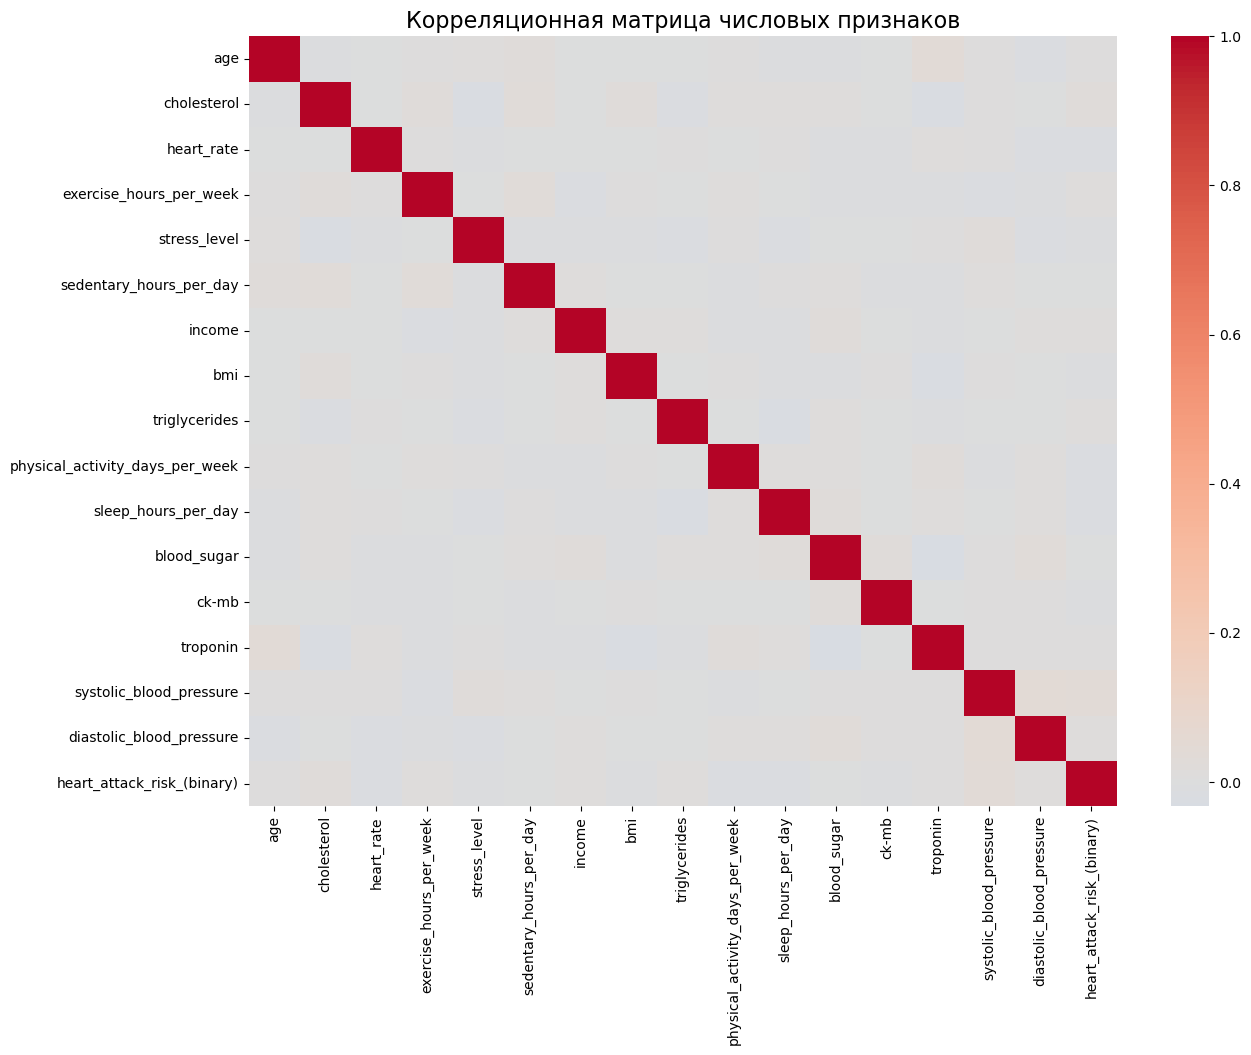

In [53]:
# матрица корреляций
corr_matrix = data_tr[num_cols + [TARGET]].corr(numeric_only=True)

# визуализация
plt.figure(figsize=(14,10))
sns.heatmap(corr_matrix, annot=False, cmap="coolwarm", center=0)
plt.title("Корреляционная матрица числовых признаков", fontsize=16)
plt.show()

	Нет ярко выраженных пар сильно коррелирующих признаков (цвет почти однородный). Это хорошо: меньше риска мультиколлинеарности.

interval columns not set, guessing: ['age', 'cholesterol', 'heart_rate', 'diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'exercise_hours_per_week', 'diet', 'previous_heart_problems', 'medication_use', 'stress_level', 'sedentary_hours_per_day', 'income', 'bmi', 'triglycerides', 'physical_activity_days_per_week', 'sleep_hours_per_day', 'heart_attack_risk_(binary)', 'blood_sugar', 'ck-mb', 'troponin', 'systolic_blood_pressure', 'diastolic_blood_pressure']


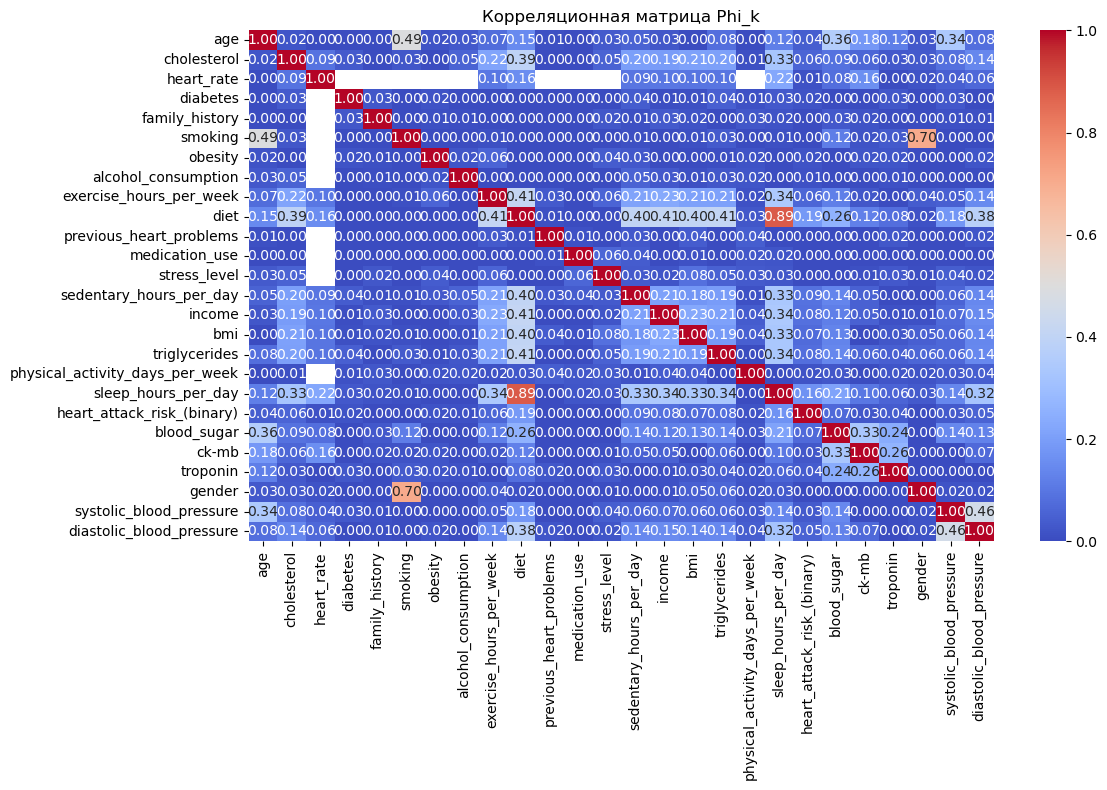

In [54]:
# добавим корреляцию  методом Phi_k

# берём train без id
data_for_phik = data_tr.drop(columns=[ID_COL]).copy()

# приводим целевой признак к int (0/1)
data_for_phik[TARGET] = data_for_phik[TARGET].astype(int)

# считаем матрицу phi_k для всех типов переменных
phik_matrix = data_for_phik.phik_matrix()

# визуализация
plt.figure(figsize=(12, 8))
sns.heatmap(phik_matrix, annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Корреляционная матрица Phi_k")
plt.tight_layout()
plt.show()

Здесь тоже нет сильных связей с таргетом. Зато можно заметить взаимосвязи между бинарными признаками (например, smoking и obesity могут давать связь между собой).

Это говорит о том, что целевой признак не имеет ярко выраженной связи ни с одной переменной по отдельности → модель должна учитывать комбинации факторов.

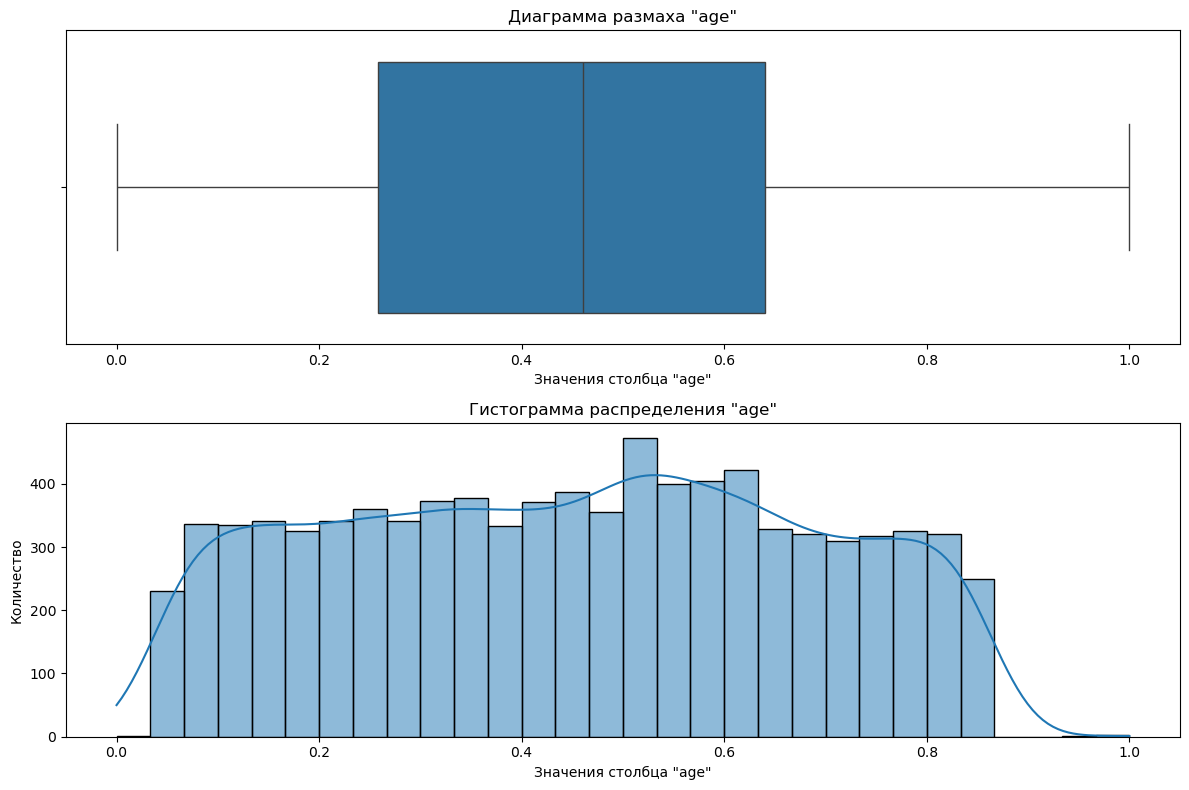

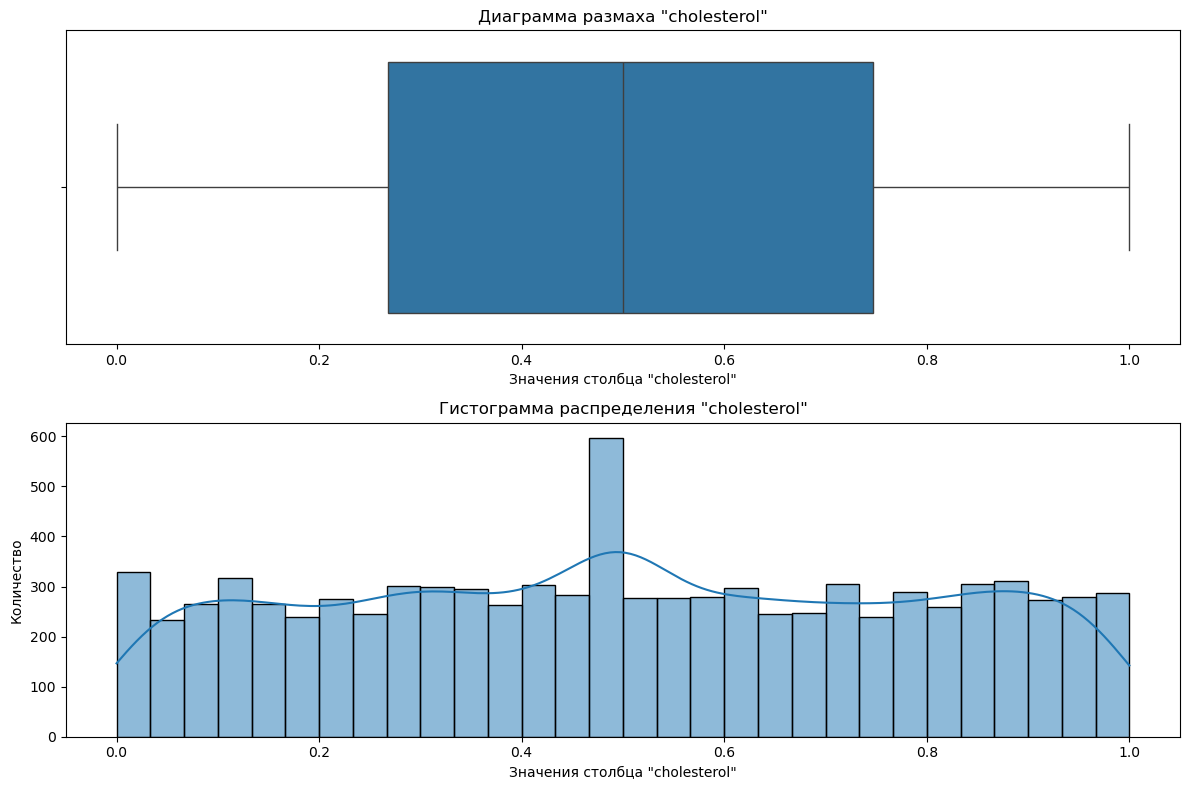

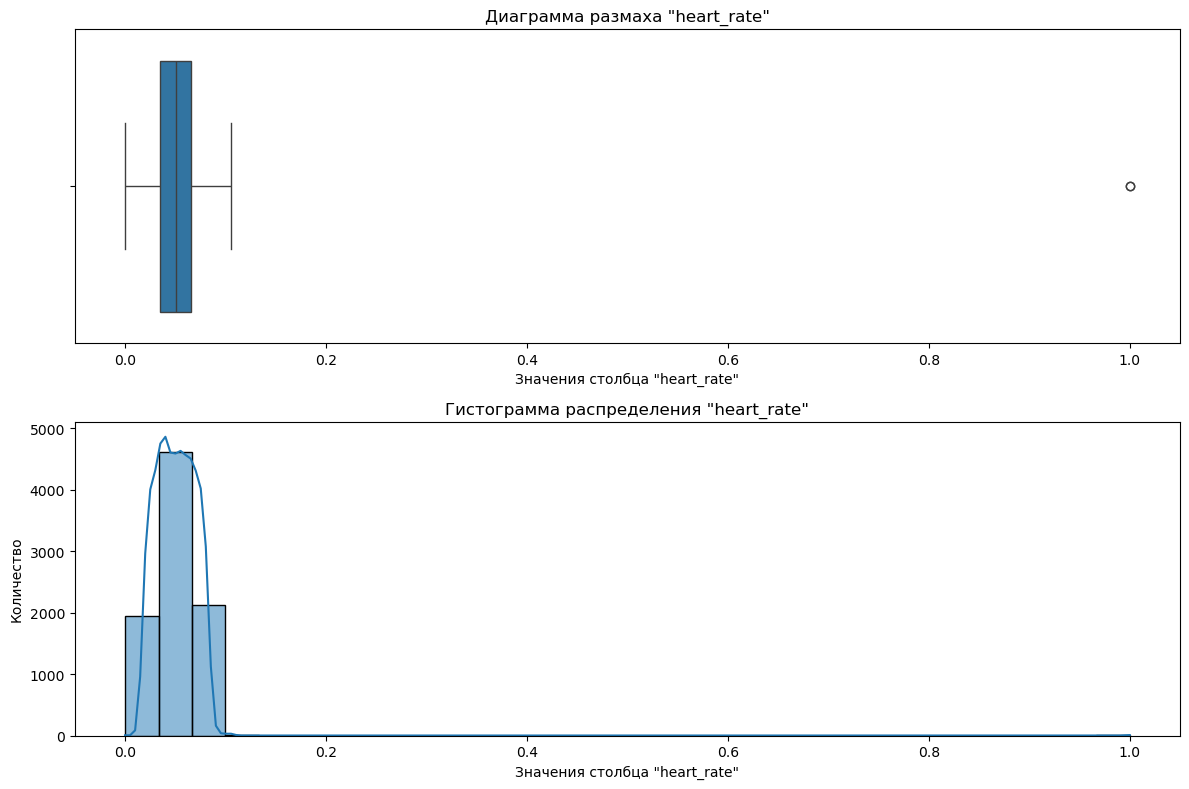

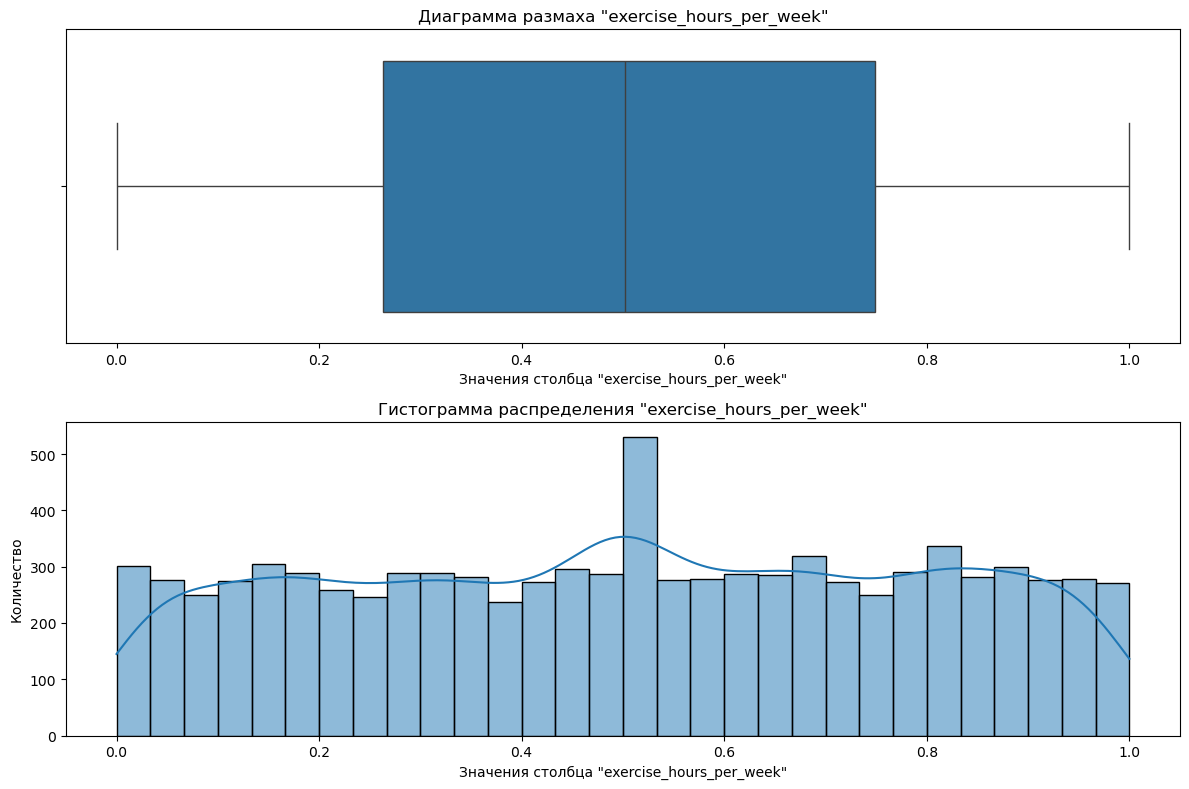

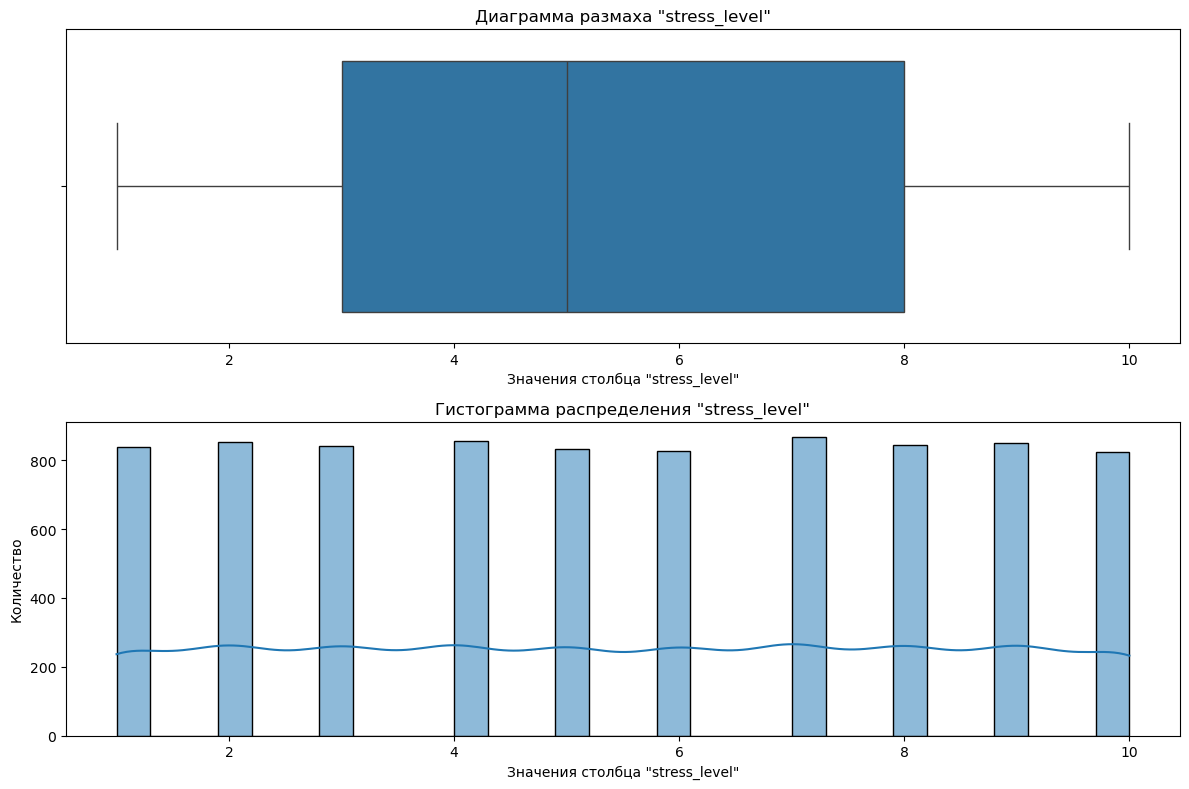

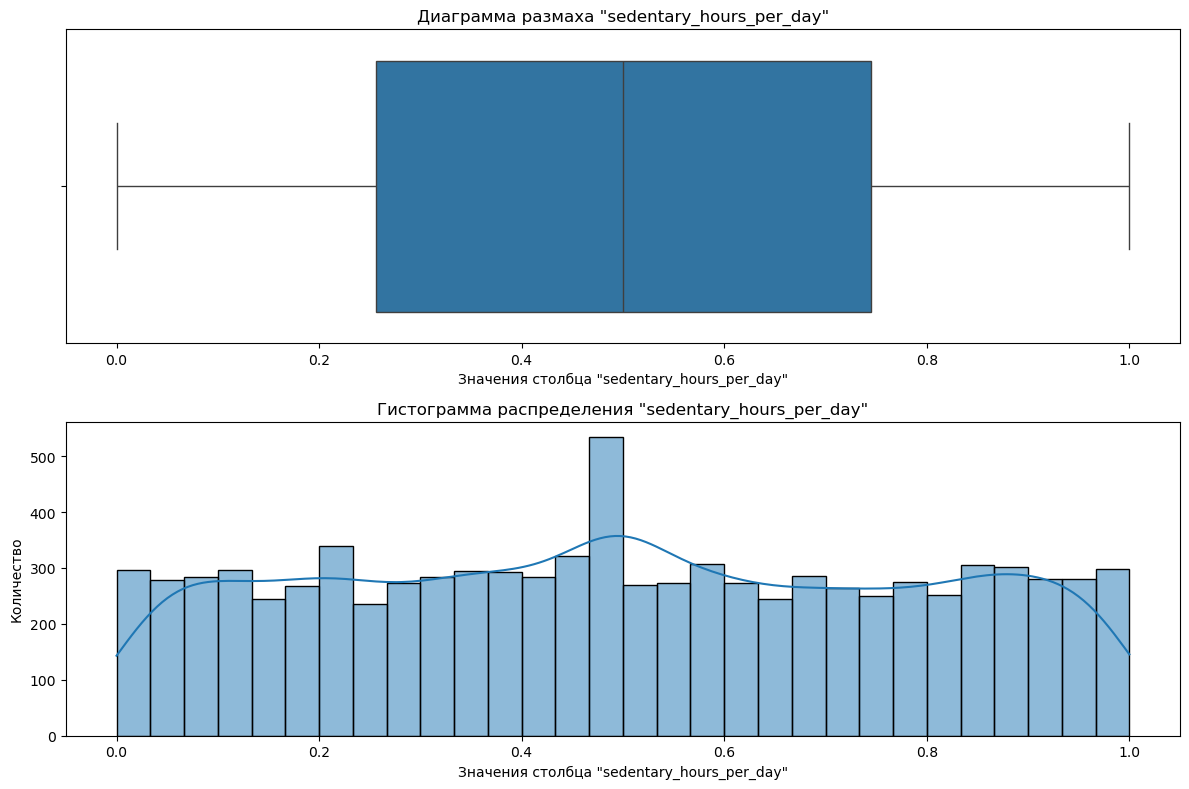

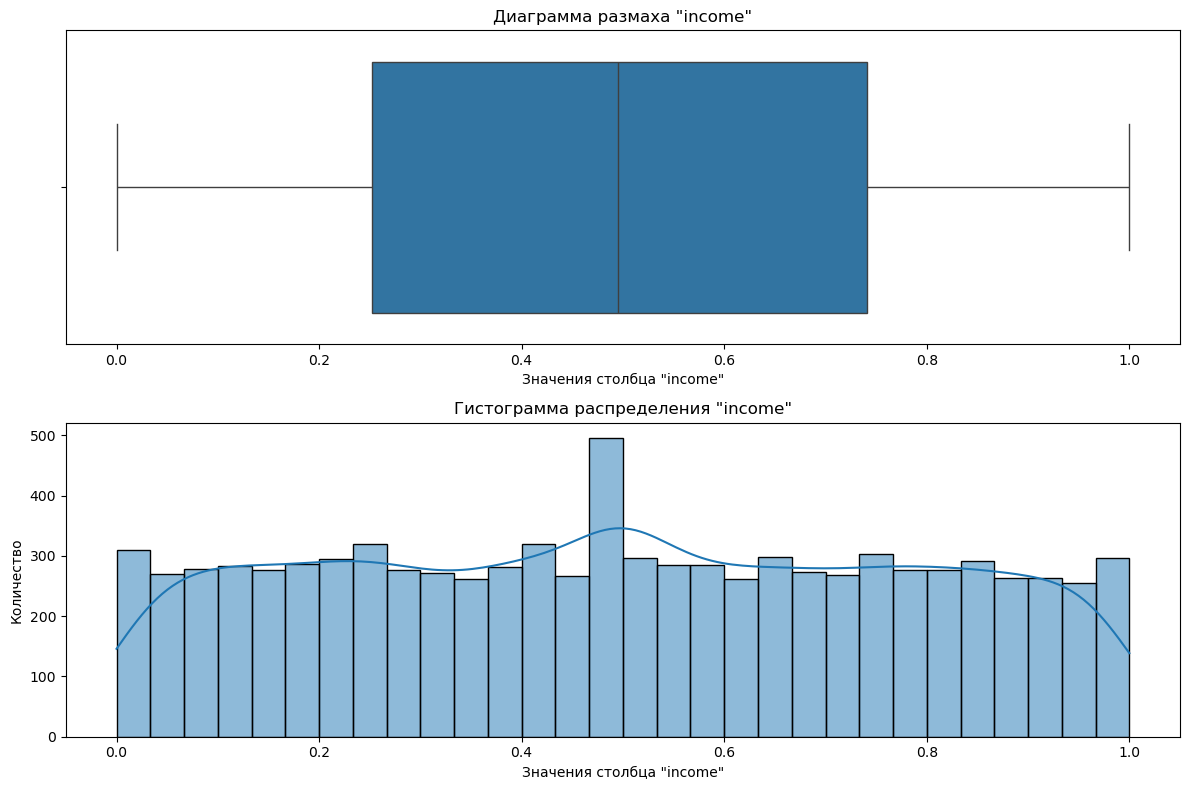

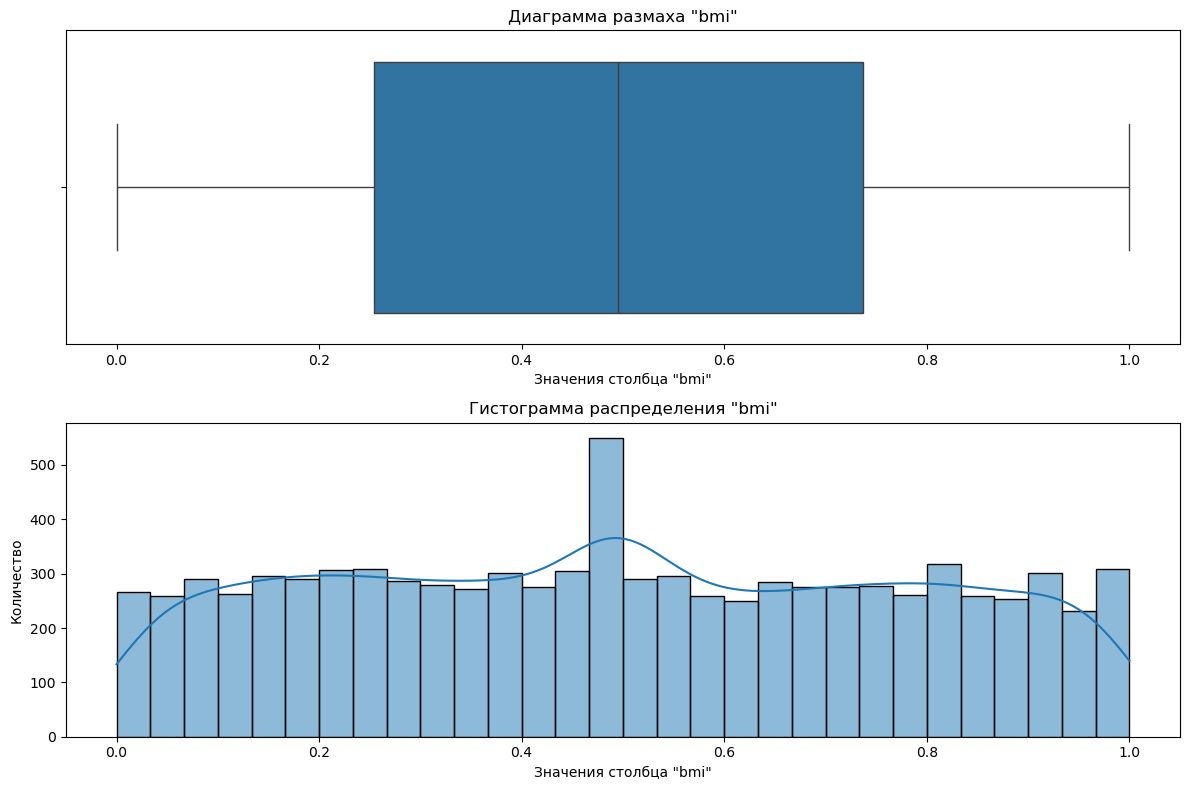

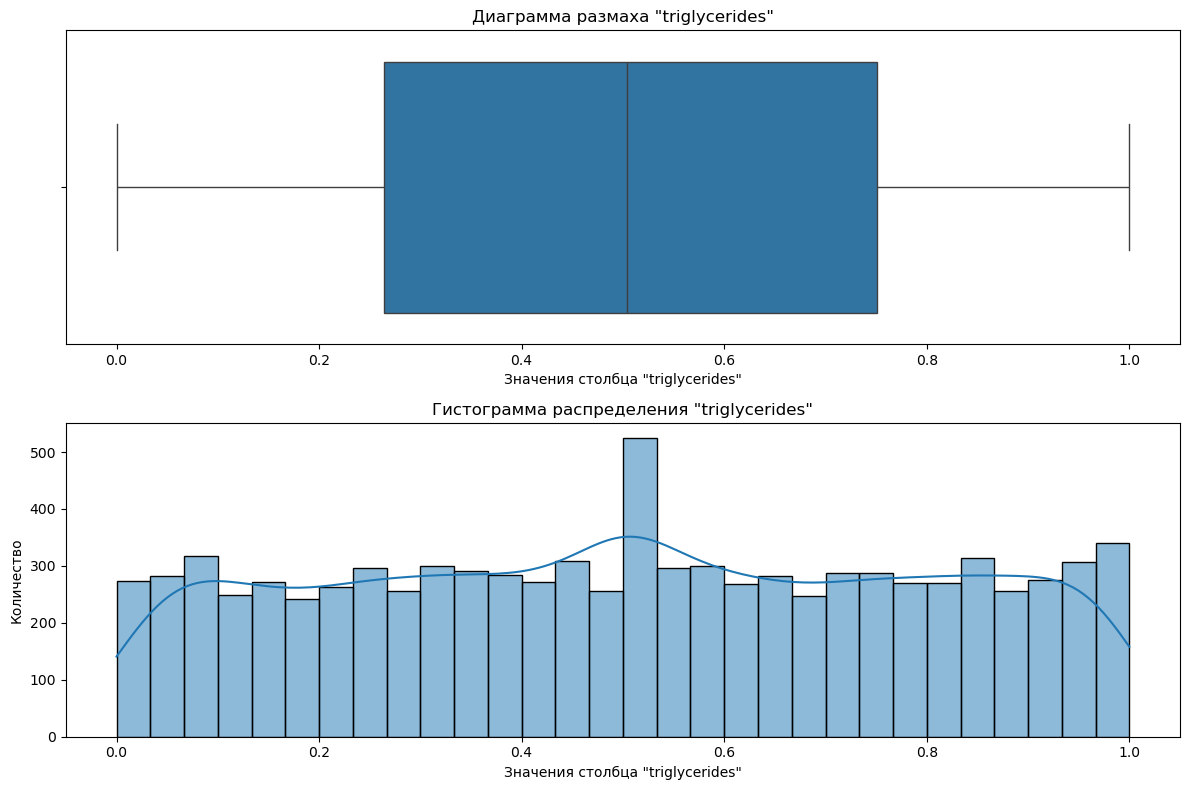

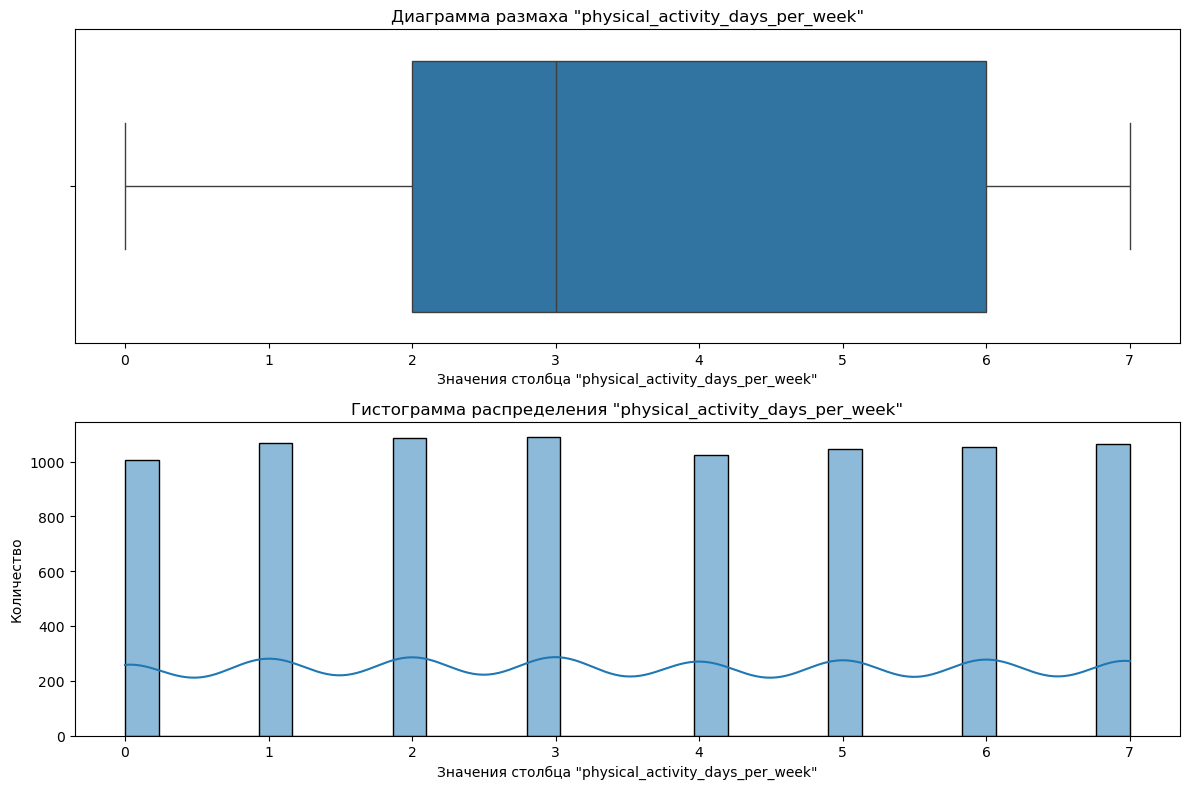

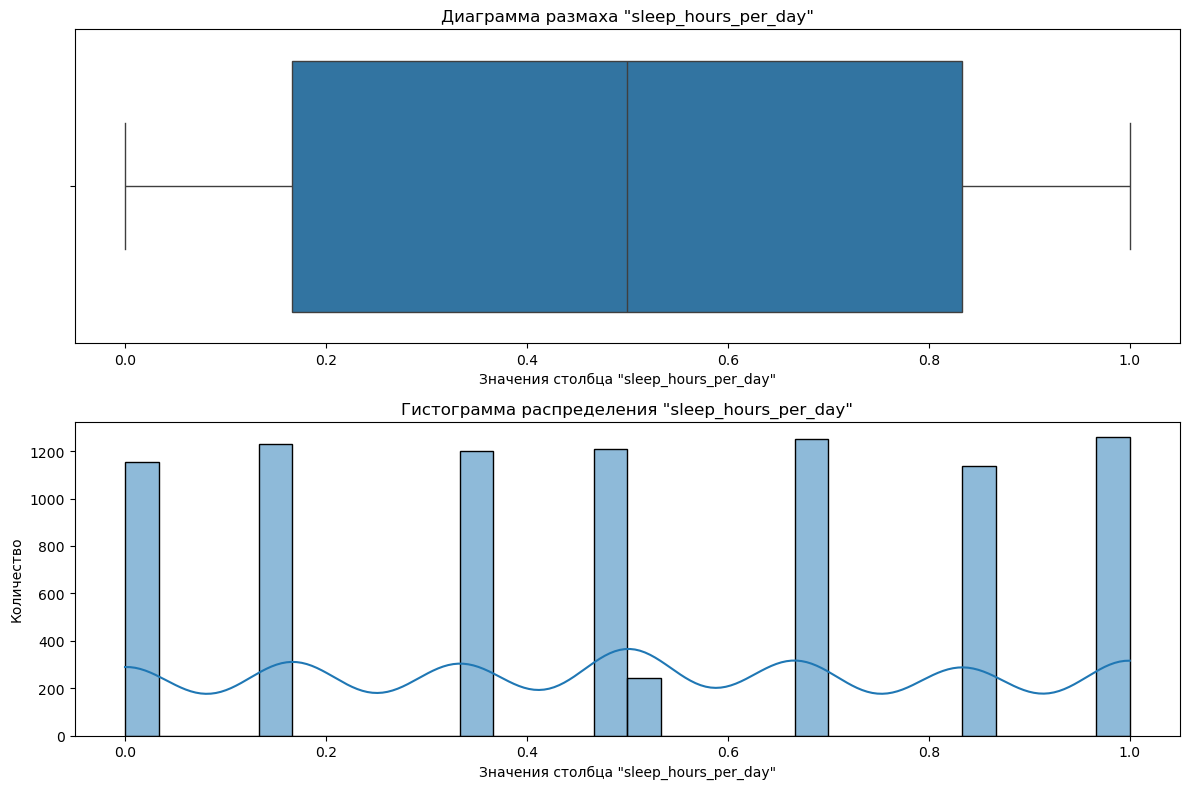

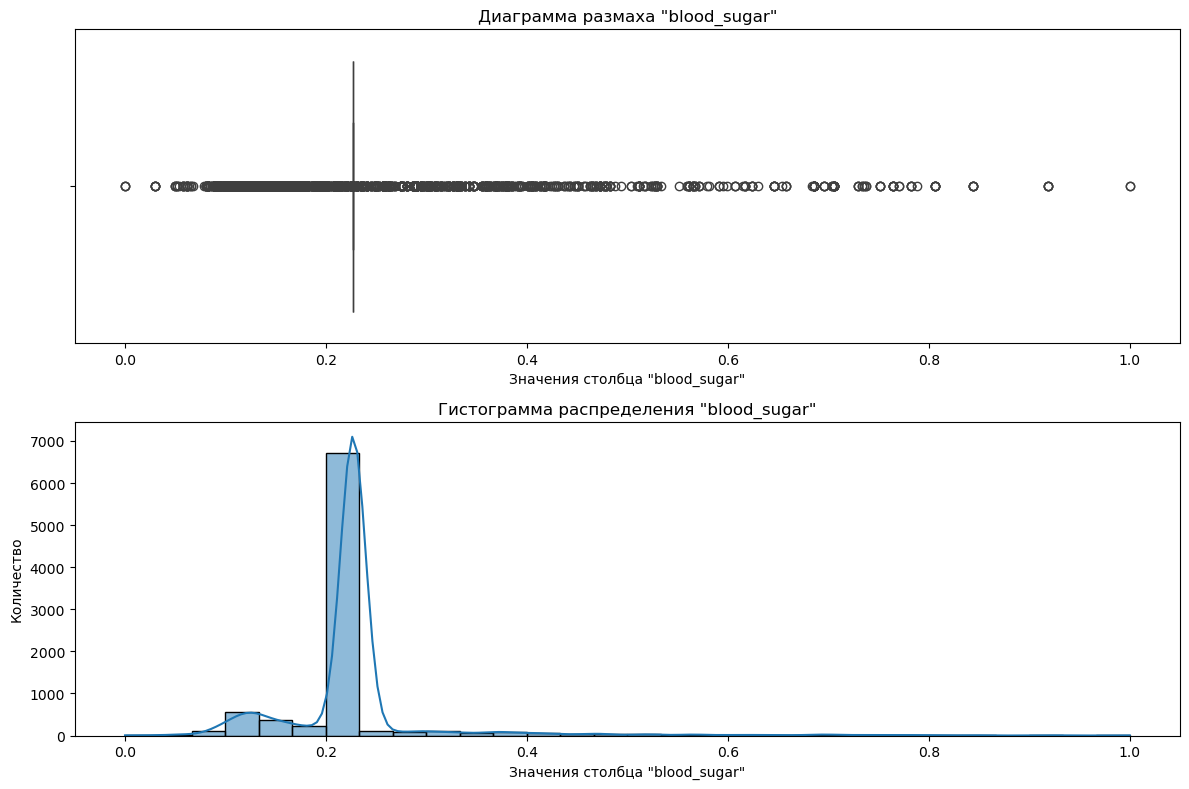

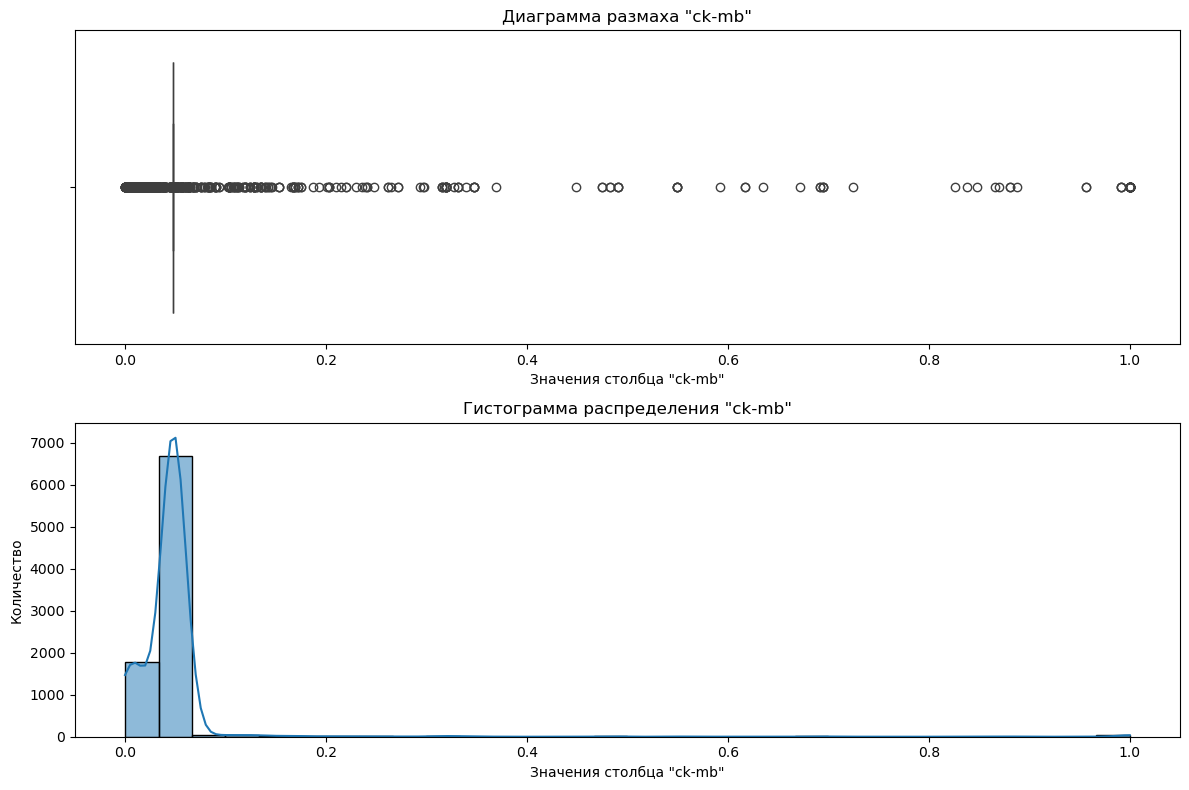

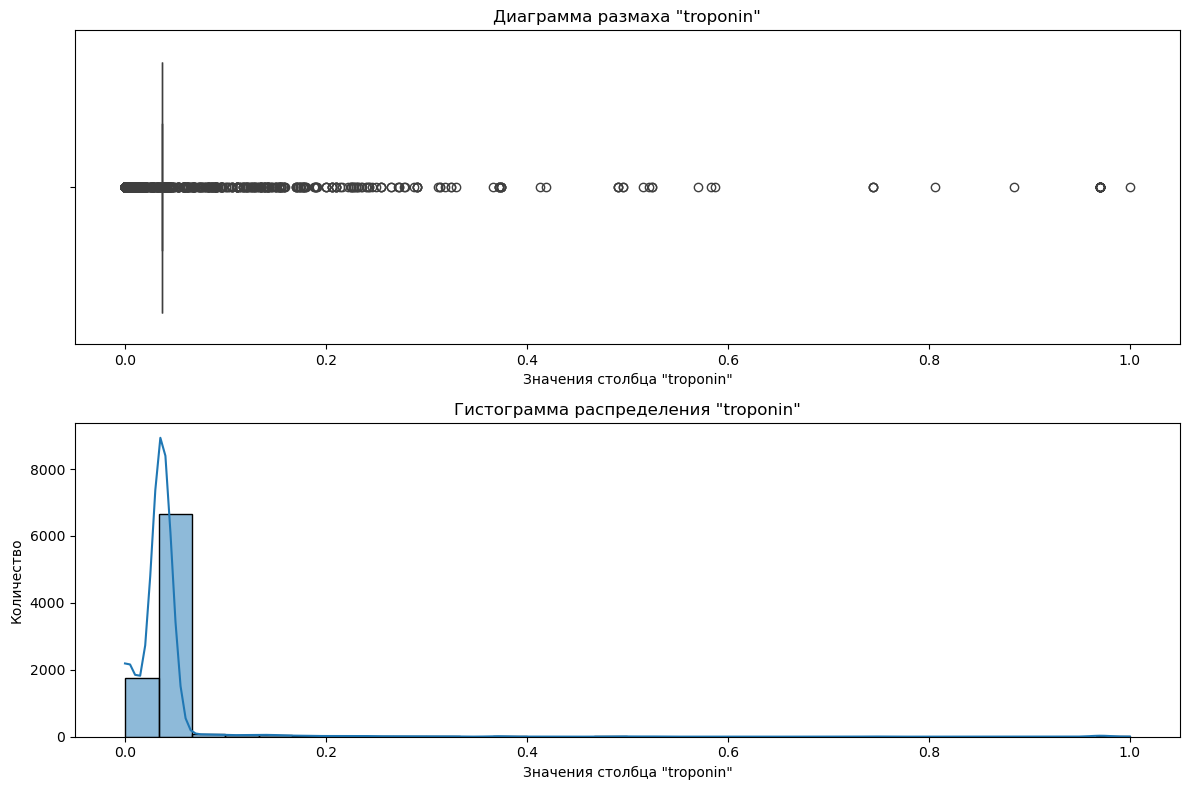

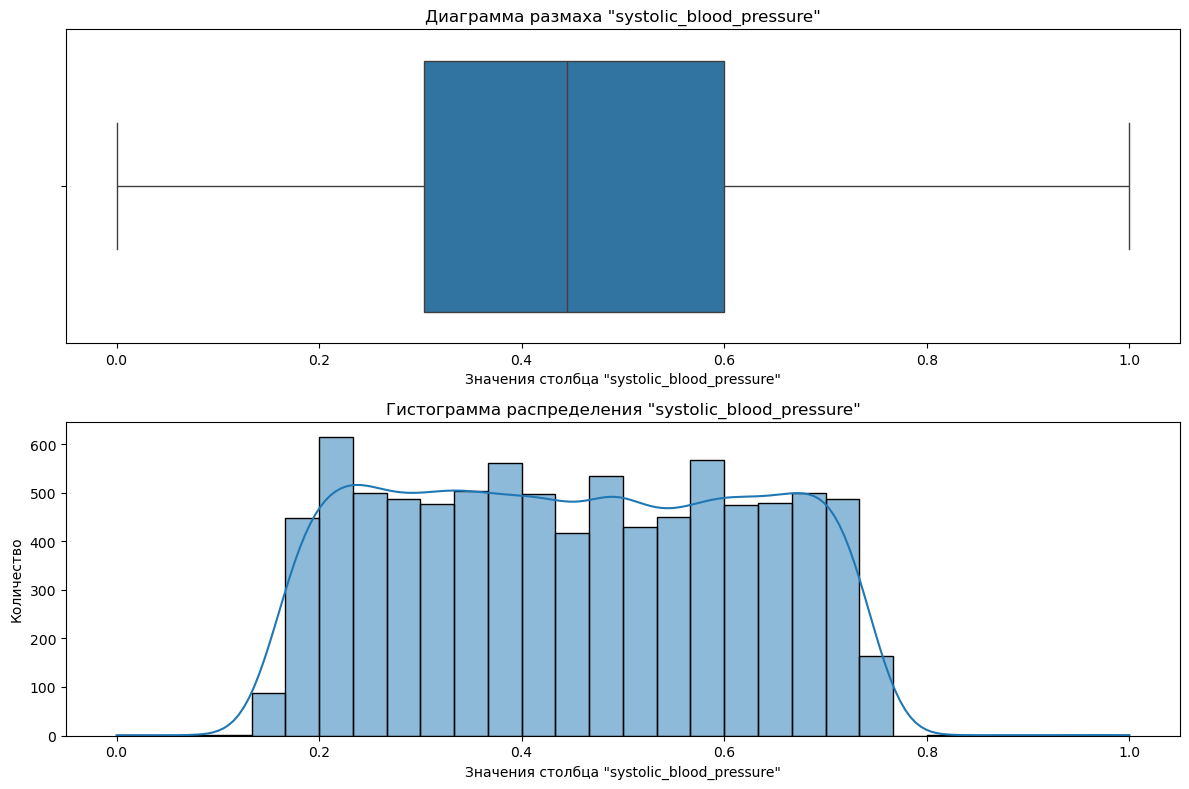

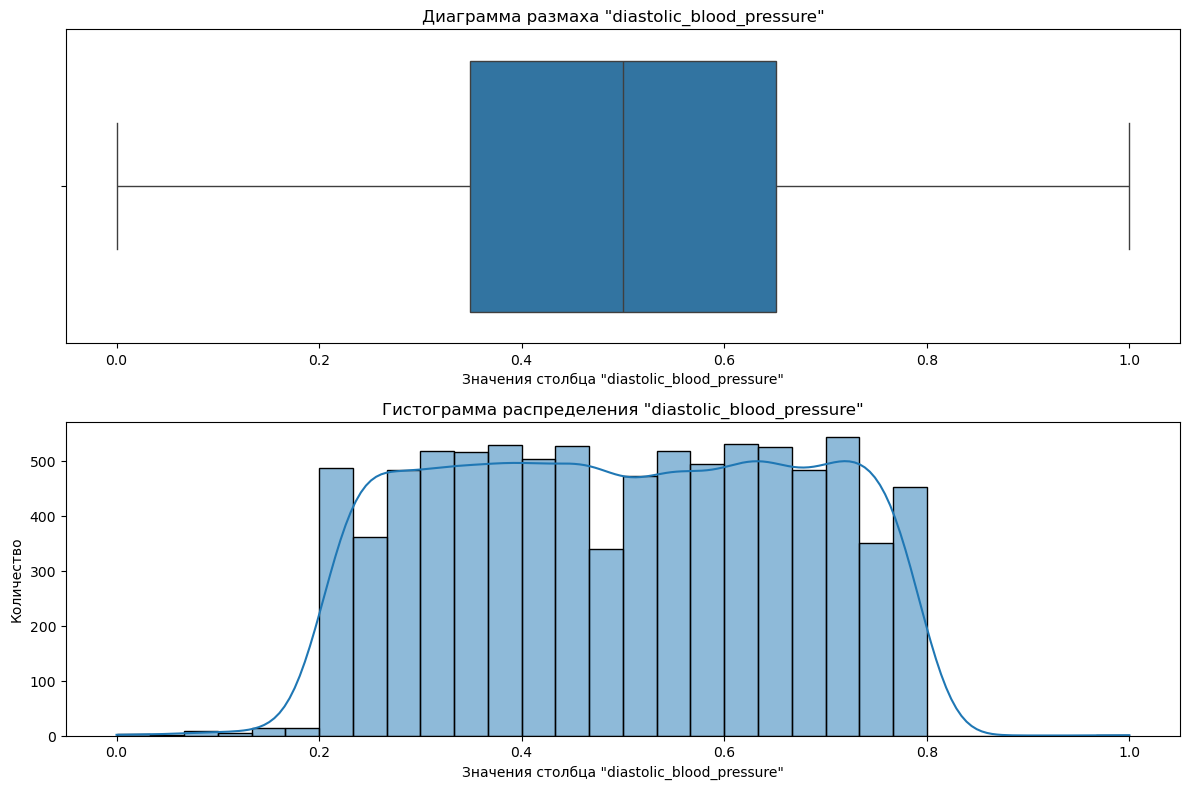

In [56]:
# Построим гистограммы и boxplot для визуализации распределения данных для каждого числового признака
for col in num_cols:
    plt.figure(figsize=(12, 8))
    
    # boxplot (по значениям признака)
    plt.subplot(2, 1, 1)
    sns.boxplot(x=data_tr[col])
    plt.xlabel(f'Значения столбца "{col}"')
    plt.title(f'Диаграмма размаха "{col}"')
    
    # гистограмма распределения
    plt.subplot(2, 1, 2)
    sns.histplot(data_tr[col], kde=True, bins=30)
    plt.xlabel(f'Значения столбца "{col}"')
    plt.ylabel('Количество')
    plt.title(f'Гистограмма распределения "{col}"')
    
    plt.tight_layout()
    plt.show()

•	У многих признаков распределение «равномерное» (похоже на заранее нормализованные данные).

•	Есть скошенные распределения (heart_rate, ck-mb, troponin) — значения сильно смещены к 0, но встречаются редкие выбросы.

•	Boxplot подтверждают: по многим признакам есть отдельные выбросные точки.

•	В признаках с «натуральными» шкалами (stress_level, physical_activity_days_per_week, sleep_hours_per_day) распределения ближе к привычным — например, стресс чаще 5–8, физическая активность чаще 2–4 дней.

Исследовательский анализ данных обычно проводится только на тренировочной выборке, но  полезно провести базовую диагностику и тестовых данных, чтобы убедиться, что они похожи на train. Сделаем это далее

In [57]:
print("Размеры test:", data_te.shape)
print("\nИнформация о типах данных:")
display(data_te.info())

Размеры test: (966, 26)

Информация о типах данных:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 966 entries, 0 to 965
Data columns (total 26 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   age                              966 non-null    float64
 1   cholesterol                      966 non-null    float64
 2   heart_rate                       966 non-null    float64
 3   diabetes                         935 non-null    float64
 4   family_history                   935 non-null    float64
 5   smoking                          935 non-null    float64
 6   obesity                          935 non-null    float64
 7   alcohol_consumption              935 non-null    float64
 8   exercise_hours_per_week          966 non-null    float64
 9   diet                             966 non-null    int64  
 10  previous_heart_problems          935 non-null    float64
 11  medication_use                  

None

In [58]:
# пропуски
null_share_test = data_te.isna().mean().sort_values(ascending=False)
print("\nTOP по пропускам (test):")
display(null_share_test.head(10))


TOP по пропускам (test):


diabetes                           0.032091
family_history                     0.032091
smoking                            0.032091
obesity                            0.032091
alcohol_consumption                0.032091
physical_activity_days_per_week    0.032091
previous_heart_problems            0.032091
medication_use                     0.032091
stress_level                       0.032091
age                                0.000000
dtype: float64

In [59]:
# описательная статистика числовых признаков
print("\nСтатистика по числовым признакам (test):")
display(data_te[num_cols].describe().T)


Статистика по числовым признакам (test):


,count,mean,std,min,25%,50%,75%,max
age,966.0,0.452916,0.231068,0.044944,0.247191,0.460674,0.640449,0.853933
cholesterol,966.0,0.488181,0.282039,0.000000,0.243750,0.499780,0.710714,0.996429
heart_rate,966.0,0.051644,0.035502,0.000000,0.036664,0.050412,0.065995,1.000000
exercise_hours_per_week,966.0,0.490706,0.284902,0.000336,0.243431,0.502110,0.734425,0.998938
stress_level,935.0,5.332620,2.858466,1.000000,3.000000,5.000000,8.000000,10.000000
sedentary_hours_per_day,966.0,0.506715,0.287826,0.001187,0.258713,0.501327,0.759591,0.999033
income,966.0,0.484408,0.273879,0.003351,0.261446,0.492015,0.705371,0.998885
bmi,966.0,0.476796,0.291987,0.002598,0.217527,0.471185,0.720503,0.999496
triglycerides,966.0,0.486688,0.284534,0.000000,0.249675,0.488961,0.718182,0.998701
physical_activity_days_per_week,935.0,3.443850,2.302778,0.000000,1.000000,3.000000,5.000000,7.000000


In [60]:
# уникальные значения категориальных признаков
print("\nКатегориальные признаки (test):")
for col in cat_cols:
    uniq = data_te[col].unique()
    print(f"{col} → {len(uniq)} уникальных: {uniq[:10]}")


Категориальные признаки (test):
gender → 2 уникальных: ['male' 'female']
diabetes → 3 уникальных: [ 0.  1. nan]
family_history → 3 уникальных: [ 1.  0. nan]
smoking → 3 уникальных: [ 1.  0. nan]
obesity → 3 уникальных: [ 1.  0. nan]
alcohol_consumption → 3 уникальных: [ 1.  0. nan]
previous_heart_problems → 3 уникальных: [ 0.  1. nan]
medication_use → 3 уникальных: [ 0.  1. nan]
diet → 4 уникальных: [2 0 1 3]


•	Размер тестовой выборки: 966 строк, 26 признаков.

•	Пропуски: встречаются в тех же колонках, что и в train. Это ожидаемо и будет обрабатываться в пайплайне.

•	Статистика числовых признаков: распределения очень похожи на train (средние и квартильные значения отличаются незначительно). Это важно — значит, test и train из одной «генеральной совокупности».

•	Категориальные признаки совпадают с train.

Исследовательский анализ данных показал:

1.	Данные в целом корректные, но имеются пропуски и выбросы, которые учтём в пайплайне.

2.	Большинство признаков слабосвязаны с таргетом по отдельности → важно использовать модели, которые умеют работать с комбинациями факторов.

3.	Явной мультиколлинеарности (дублирования признаков) не обнаружено.

4.	Распределения числовых признаков разные: часть нормирована, часть совсем неравномерно распределены. Выбросы есть, но они не критичны для деревьев решений.
    
5.	Категориальные признаки подготовлены (gender, binary-флаги, diet) и будут закодированы в OHE.

6. 	Train и test сопоставимы: распределения схожи, структура одинакова, новые категории не появились.

На этом исследовательский анализ закончен, можно переходить к подготовке признаков в пайплайне.

4. ПОДГОТОВКА ДАННЫХ

In [74]:
# базовые X, y
X = data_tr.drop(columns=[TARGET, ID_COL])
y = data_tr[TARGET]

# задаем группы признаков
binary_features = [
    "diabetes", "family_history", "smoking", "obesity",
    "alcohol_consumption", "previous_heart_problems", "medication_use"
]  

cat_onehot = ["gender", "diet"]  

num_features = [c for c in X.columns if c not in set(binary_features + cat_onehot)]

print("num_features:", len(num_features))
print("cat_onehot  :", cat_onehot)
print("binary      :", binary_features)

# пайплайны по группам
num_pipeline_sav = Pipeline([
    ("imputer", SimpleImputer(strategy="median")),
    ("scaler",  StandardScaler(with_mean=False)),
])

onehot_pipeline = Pipeline(steps=[
    ("imputer", SimpleImputer(strategy="most_frequent")),
    ("encoder", OneHotEncoder(handle_unknown="ignore", drop='first'))
])

# для бинарных кодирования не нужно — это уже 0/1; заполним пропуски и приведём к int
binary_pipeline_sav = Pipeline([
    ("imputer", SimpleImputer(strategy="most_frequent")),
])

# итоговый ColumnTransformer
preprocessor = ColumnTransformer([
    ("num",        num_pipeline_sav,  num_features),
    ("cat_onehot", onehot_pipeline, cat_onehot),
    ("bin",        binary_pipeline_sav, binary_features),
])

print("Готов объект preprocessor.")

# глобальные параметры
RANDOM_STATE = 42
TEST_SIZE = 0.2

# делим данные
X_tr, X_val, y_tr, y_val = train_test_split(
    X, y, test_size=0.2, stratify=y
)

# самопроверка формы (без обучения модели)
prep_only = Pipeline([("pre", preprocessor)])
prep_only.fit(X_tr)  # fit только на train, без утечки

X_tr_prepared = prep_only.transform(X_tr)
X_val_prepared = prep_only.transform(X_val)
X_te_prepared  = prep_only.transform(data_te.drop(columns=[ID_COL]))

print("Формы после препроцессинга:",
      "train", X_tr_prepared.shape,
      "| valid", X_val_prepared.shape,
      "| test",  X_te_prepared.shape)

num_features: 16
cat_onehot  : ['gender', 'diet']
binary      : ['diabetes', 'family_history', 'smoking', 'obesity', 'alcohol_consumption', 'previous_heart_problems', 'medication_use']
Готов объект preprocessor.
Формы после препроцессинга: train (6948, 27) | valid (1737, 27) | test (966, 27)


Признаки разделены на группы:

• числовые (16 признаков)- пропуски заполнены медианой, стандартизация,

• категориальные (gender, diet) → мода + OneHot (drop=first, чтобы избежать дамми-ловушки),

• бинарные  (0/1) → мода + приведение к int.

	Все шаги собраны в единый ColumnTransformer (preprocessor).

	Сделан train/valid split (80/20, стратифицированный).

	Проверка прошла успешно: train → 6948 признаковых строк, valid → 1737, test → 966, после препроцессинга у всех получилось одинаковое число столбцов (27).

	Значит, пайплайн готов к использованию внутри моделей — можно переходить к их обучению.

5. ОБУЧЕНИЕ МОДЕЛЕЙ

	Для оценки качества моделей будем использовать следующие метрики:
•	ROC‑AUC (основная): классы несбалансированы; метрика независима от порога и оценивает качество ранжирования (для «оценки риска» это то, что нужно).

•	PR‑AUC (доп.): подчёркивает качество по положительному классу (высокий риск), полезно при дисбалансе.

•	F1: считаем после подбора порога на валидации — если понадобится именно бинарное решение (0/1).

In [75]:
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)

# 1 модель -  RandomForest
model_rf = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
])

param_grid_rf = {
    'clf__n_estimators': [200, 400],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

grid_rf = GridSearchCV(
    estimator=model_rf,
    param_grid=param_grid_rf,
    scoring='roc_auc',    
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid_rf.fit(X_tr, y_tr)
best_rf = grid_rf.best_estimator_
print("RF | лучший CV ROC-AUC:", grid_rf.best_score_)
print("RF | лучшие гиперпараметры:", grid_rf.best_params_)

# 2 модель -  ExtraTrees
model_et = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('clf', ExtraTreesClassifier(random_state=RANDOM_STATE, class_weight='balanced', n_jobs=-1))
])

param_grid_et = {
    'clf__n_estimators': [400, 600],
    'clf__max_depth': [None, 10, 20],
    'clf__min_samples_split': [2, 5],
    'clf__min_samples_leaf': [1, 2]
}

grid_et = GridSearchCV(
    estimator=model_et,
    param_grid=param_grid_et,
    scoring='roc_auc',    
    cv=cv,
    n_jobs=-1,
    verbose=0
)

grid_et.fit(X_tr, y_tr)
best_et = grid_et.best_estimator_
print("\nET | лучший CV ROC-AUC:", grid_et.best_score_)
print("ET | лучшие гиперпараметры:", grid_et.best_params_)


RF | лучший CV ROC-AUC: 0.5856129845899118
RF | лучшие гиперпараметры: {'clf__max_depth': 20, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 2, 'clf__n_estimators': 400}

ET | лучший CV ROC-AUC: 0.582968552184254
ET | лучшие гиперпараметры: {'clf__max_depth': None, 'clf__min_samples_leaf': 1, 'clf__min_samples_split': 5, 'clf__n_estimators': 400}


In [76]:
# выбираем лучшую модель по CV ROC-AUC
if grid_et.best_score_ >= grid_rf.best_score_:
    best_name = "ExtraTrees"
    best_model = best_et
    best_cv_score = grid_et.best_score_
else:
    best_name = "RandomForest"
    best_model = best_rf
    best_cv_score = grid_rf.best_score_

print(f"\nЛучшее по CV ROC-AUC: {best_name} | {best_cv_score:.4f}")

# оценка на валидации  + подбор порога под F1
val_proba = best_model.predict_proba(X_val)[:, 1]
roc = roc_auc_score(y_val, val_proba)                 
pr  = average_precision_score(y_val, val_proba)       

prec, rec, thr = precision_recall_curve(y_val, val_proba)
f1s = 2*prec*rec/(prec+rec+1e-12)
best_idx = int(np.nanargmax(f1s))
best_thr = float(thr[max(0, best_idx-1)]) if best_idx >= 1 else 0.5

val_pred = (val_proba >= best_thr).astype(int)
f1  = f1_score(y_val, val_pred)

print(f"\nВалидация ({best_name}):")
print(f"ROC-AUC: {roc:.3f} | PR-AUC: {pr:.3f} | F1@best_thr={best_thr:.3f}: {f1:.3f}")
print("Classification report @best_thr:")
print(classification_report(y_val, val_pred, digits=3))


Лучшее по CV ROC-AUC: RandomForest | 0.5856

Валидация (RandomForest):
ROC-AUC: 0.587 | PR-AUC: 0.445 | F1@best_thr=0.272: 0.542
Classification report @best_thr:
              precision    recall  f1-score   support

         0.0      0.950     0.118     0.210      1134
         1.0      0.373     0.988     0.542       603

    accuracy                          0.420      1737
   macro avg      0.662     0.553     0.376      1737
weighted avg      0.750     0.420     0.325      1737



Сравнили RandomForest и ExtraTrees через GridSearchCV (5‑fold, stratified, scoring=ROC‑AUC).

Лучшей стала RandomForest: CV ROC‑AUC ≈ 0.586.

На валидации: ROC‑AUC ≈ 0.587, PR‑AUC ≈ 0.445.

Порог: выбран по максимуму F1 (≈ 0.272), что даёт очень высокий recall по классу 1 (≈ 0.99) ценой снижения precision — разумно для сценария «лучше не пропустить риск».

Итог: модель адекватно ранжирует пациентов по риску; бинарный режим можно настраивать порогом под нужный баланс precision/recall.

In [77]:
# дообучаем лучшую модель на всех обучающих данных
best_model.fit(X, y)

# вероятности для теста 
test_proba = best_model.predict_proba(data_te.drop(columns=[ID_COL]))[:, 1]

# сабмит с вероятностями (id, prediction)
sub_proba = pd.DataFrame({ID_COL: data_te[ID_COL], "prediction": test_proba})
sub_proba.to_csv("submission_proba.csv", index=False)

# бинарный сабмит по найденному порогу best_thr
sub_bin = pd.DataFrame({ID_COL: data_te[ID_COL], "prediction": (test_proba >= best_thr).astype(int)})
sub_bin.to_csv("submission_binary.csv", index=False)

print("Saved: submission_proba.csv  |  submission_binary.csv")
print("Использованный порог для бинарного:", round(best_thr, 3))

Saved: submission_proba.csv  |  submission_binary.csv
Использованный порог для бинарного: 0.272


In [78]:
# сохраняем модель
joblib.dump(best_model, "best_model.joblib")

# сохраняем выбранный порог
with open("best_threshold.json", "w") as f:
    json.dump({"best_thr": float(best_thr)}, f)

print("Saved: best_model.joblib, best_threshold.json")

Saved: best_model.joblib, best_threshold.json


6. ВЫВОДЫ

Задачей проекта было:

Построить модель, которая по данным о пациентах (антропометрия, привычки, давление, хронические заболевания, биохимия крови) предсказывает риск сердечного приступа (низкий/высокий).

Цель — помочь врачам и системам мониторинга вовремя определять пациентов из группы риска.



Работа включала следующие этапы

Загрузка и изучение данных

•	Загружены тренировочная и тестовая выборки.

•	Проверены типы данных, пропуски и дубликаты.

•	Обнаружены пропуски в 9 признаках (в основном бинарные и поведенческие).

•	Колонка gender содержала некорректные значения (Male/Female/0/1), приведена к единому виду.

•	Признаки приведены к snake_case для удобства работы.

Исследовательский анализ данных 

•	Построены описательные статистики, гистограммы и boxplot для всех числовых признаков.

•	Выполнен анализ корреляций (Пирсон и Phi_k). Явных сильных связей с целевым признаком не выявлено.

•	Train и test выборки оказались сопоставимыми по распределениям и уникальным значениям.

•	Выбросы отмечены в биохимических маркёрах (например, ck-mb, troponin), но деревья решений устойчивы к ним.

Подготовка данных

•	Созданы пайплайны предобработки:

•	числовые признаки - заполнение медианой + стандартизация,

•	бинарные признаки (0/1) - заполнение модой,

•	категориальные (gender, diet) - заполнение модой + OneHotEncoder.

•	Весь препроцессинг реализован в ColumnTransformer и встроен в общий Pipeline.

•	Выполнено разделение train/validation для оценки качества моделей.

Обучение модели

•	Сравнены две ансамблевые модели: RandomForestClassifier и ExtraTreesClassifier.

•	Подбор гиперпараметров выполнен через GridSearchCV (StratifiedKFold, 5 фолдов).

•	Лучшая модель — RandomForest с CV ROC-AUC ≈ 0.586.

•	На валидации: ROC-AUC ≈ 0.587, PR-AUC ≈ 0.445.

•	Подобран порог под максимум F1 (≈0.27), что обеспечило очень высокую Recall по классу «высокий риск» (0.99), ценой снижения точности.

Формирование предсказаний

•	Модель дообучена на всей тренировочной выборке.

•	Сформированы файлы:

•	submission_proba.csv — вероятности,

•	submission_binary.csv — классы по подобранному порогу.

•	Модель и порог сохранены (best_model.joblib, best_threshold.json).



Финальные выводы и рекомендации

1.	Выбор метрики

Основная метрика — ROC-AUC: она устойчива к дисбалансу классов и оценивает качество ранжирования риска. Дополнительно использованы PR-AUC (фокус на положительном классе) и F1 (после подбора порога).

2.	Качество модели

Итоговый ROC-AUC ≈ 0.59 — модель лучше случайного предсказания, но имеет ограниченную силу. Это ожидаемо: признаки по отдельности слабо связаны с таргетом, важны их нелинейные комбинации.

3.	Практическое применение

•	Модель можно использовать для ранжирования пациентов по вероятности риска: верхний квантиль = пациенты, требующие приоритетного внимания.
	
•	Порог можно варьировать: для медицинской задачи логично выбирать режим с максимальной полнотой (recall), чтобы минимизировать число пропущенных случаев.

⸻

📌 Таким образом, цель проекта достигнута: построена воспроизводимая модель предсказания риска сердечного приступа, собраны сабмиты, подготовлены артефакты для возможного внедрения в сервис.